# Fully-connected neural networks
Training, prediction, and visualisation of the multi-label classification by fully-connected neural networks based on linear regression and MLP.  

## Settings

In [1]:
base = "data"
dataset = "nist"
kind = "de_novo"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"


%load_ext autoreload
%autoreload 2

In [2]:
# compounds to visualize 
if kind == "in_database":
    interesting =  ["Atrazine", "Carbofuran", "Monocrotophos", "Mevinphos", "Testosterone"]
elif kind == "de_novo":
    interesting =  ["Metobromuron", "Picoxystrobin", "Cyphenothrin", "Mirex"]

## Data loading

In [3]:
# from matchms.importing import load_from_msp

from matchms.importing import load_from_msp

from msai.utils import get_mz_vector, get_his_size
from msai.data import spectrum_processing
from msai.data import FixedSizeDS

from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch
import torch.nn as nn
import tqdm
import torch.nn.functional as F

# only for visual 
from spec2vec import SpectrumDocument
from data_utils import BasicCoder


In [4]:
def get_spectra(path):
    # Load data from MSP file and apply filters
    spectrums = [spectrum_processing(s, min_rel_int=None) for s in load_from_msp(path)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    # Create spectrum documents
    return spectrums

spectrums_train = get_spectra(data_train_path)
spectrums_val = get_spectra(data_val_path)
spectrums_test = get_spectra(data_test_path)

In [5]:
documents_val = [SpectrumDocument(s, n_decimals=0) for s in spectrums_val]
documents_test = [SpectrumDocument(s, n_decimals=0) for s in spectrums_test]

In [6]:
datasets = {
    "fixed_train": FixedSizeDS(spectrums_train), 
    "fixed_val": FixedSizeDS(spectrums_val), 
    "fixed_test": FixedSizeDS(spectrums_test)
}

dataloaders = {
    "train": DataLoader(datasets["fixed_train"], batch_size=1024, shuffle=True, num_workers=8),
    "val": DataLoader(datasets["fixed_val"], batch_size=1024, shuffle=True, num_workers=8),
    "test": None
}

In [7]:
datasets["fixed_train"][0][1].sum()

tensor(2.)

## Models definition

In [8]:
class Linear(nn.Module):
    def __init__(self, max_mz=1001):
        super(Linear, self).__init__()
        self.in_features = max_mz
        self.out_features = max_mz
    
        self.linear = nn.Linear(self.in_features, self.out_features)
        self.sigm = nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear(x)
        return self.sigm(x)
    
class MLP(nn.Module):
    def __init__(self, max_mz=1001, hidden_layers=(2000,)):
        super(MLP, self).__init__()
        self.in_features = max_mz
        self.out_features = max_mz
        
        assert len(hidden_layers) != 0
        self.relu = nn.ReLU()        
        layers = [nn.Linear(self.in_features, hidden_layers[0])]
        
        for i in range(len(hidden_layers)-1):
            layers.append(self.relu)
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            
        
        self.layers = nn.Sequential(*layers)
        self.linear = nn.Linear(hidden_layers[-1], self.out_features)
        self.sigm = nn.Sigmoid()

        
    def forward(self, x):
        x = self.layers(x)
        x= self.relu(x)
        x = self.linear(x)
        return self.sigm(x)
    

In [9]:
linear = Linear(datasets["fixed_train"].max_mz)
mlp_1 = MLP(datasets["fixed_train"].max_mz, (1000,))
mlp_2 = MLP(datasets["fixed_train"].max_mz, (1000,1000))
mlp_3 = MLP(datasets["fixed_train"].max_mz, (1000,1000, 1000))
mlp_1s = MLP(datasets["fixed_train"].max_mz, (500,))
mlp_2s = MLP(datasets["fixed_train"].max_mz, (500,500))
mlp_3s = MLP(datasets["fixed_train"].max_mz, (500,500, 500))

## Training


In [10]:
class Learner:
    def __init__(self, train_loader, val_loader, model, optimizer, loss_fn, \
                 device, model_name="model"):
        self.train_loader= train_loader
        self.val_loader = val_loader
        self.model = model 
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.model_name=model_name
        self.train_losses = []
        self.val_losses = []
        
        
    def evaluate(self, loader):
        eval_loss = 0
        self.model.eval()
        self.model.to(self.device)
        for b, (X, y) in enumerate(loader):
            with torch.no_grad():
                
                X, y = X.to(device), y.to(device)
                pred = self.model(X)
                
                loss = self.loss_fn(pred, y)
                eval_loss += loss.item()
            
        eval_loss /= len(loader)
        
        return eval_loss
    
    def train(self,n_epochs, early_stopping=True, patience=3, verbose=False):
        self.model.to(self.device)

        if early_stopping:
            min_val_loss = np.inf
            no_improve = 0
        
        
        e_bar = tqdm.tqdm(range(n_epochs), total=n_epochs, leave=True, desc="Epoch: ")
        for e in e_bar:
            # train
            train_loss = 0
            self.model.train()
            for b, (X, y) in enumerate(self.train_loader):
                X, y = X.to(device), y.to(device)
                # zero the parameter gradients
                self.optimizer.zero_grad()

                pred = self.model(X)
                
                loss = self.loss_fn(pred, y)
                loss.backward()

                self.optimizer.step()

                if verbose and b % (len(self.train_loader)//100) == 0:
                    print(f"Done: {b}/{len(self.train_loader)}")
            
            # evaluate (train, validation)
            train_loss = self.evaluate(self.train_loader)
            val_loss = self.evaluate(self.val_loader)

            # early stopping
            if early_stopping:
                if val_loss < min_val_loss:
                    min_val_loss = val_loss
                    torch.save(self.model, f"models/{kind}/{self.model_name}")
                    no_improve = 0
                else:
                    no_improve += 1
            if no_improve > patience:
                print("Early stopped")
                self.model = torch.load(f"models/{kind}/{self.model_name}")
                break
            
            e_bar.set_postfix({'Train loss': f"{train_loss:.3}",'Val loss': f"{val_loss:.3}" })
                
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            np.save(f"losses/{kind}/{self.model_name}_train_loss.npy", self.train_losses)
            np.save(f"losses/{kind}/{self.model_name}_val_loss.npy", self.val_losses)

        np.save(f"losses/{kind}/{self.model_name}_train_loss.npy", self.train_losses)
        np.save(f"losses/{kind}/{self.model_name}_val_loss.npy", self.val_losses)
        
        return self.train_losses, self.val_losses
    

In [14]:
# discver whether to use GPU or not
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print(device)


cpu


/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:104.)
  return torch._C._cuda_getDeviceCount() > 0


In [12]:
from msai.plots import plot_training

def train(model, train_loader, val_loader, model_name, lr=1e-3, \
          patience=3, max_epoch=500, device="cpu"):
    
    model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss(reduction="mean")
    
    learner = Learner(train_loader, val_loader, model, optim, loss_fn, device, model_name)
    train_losses, val_losses = learner.train(max_epoch, True, patience)
    plot_training(learner)
    model.to("cpu")
    return train_losses, val_losses

In [13]:
pytorch_total_params = sum(p.numel() for p in linear.parameters() if p.requires_grad)

print(f"Trainable params: {pytorch_total_params//(10**6)}M")

Trainable params: 1M


Epoch:  19%|█▉        | 94/500 [30:50<2:13:12, 19.69s/it, Train loss=0.0292, Val loss=0.0297]

Early stopped


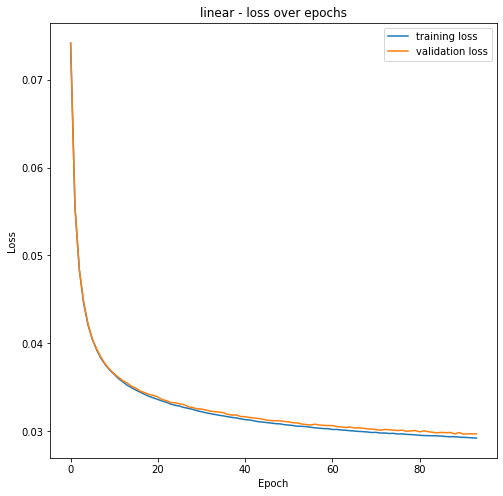

In [14]:
train_losses, val_losses = train(linear, dataloaders["train"], dataloaders["val"], "linear",\
                                 lr=1e-2, patience=10, max_epoch=500, device=device)

In [15]:
pytorch_total_params = sum(p.numel() for p in mlp_1.parameters() if p.requires_grad)
print(f"Trainable params: {pytorch_total_params//(10**6)}M")

Trainable params: 2M


Epoch:  30%|███       | 151/500 [49:38<1:54:43, 19.72s/it, Train loss=0.0216, Val loss=0.0223]

Early stopped


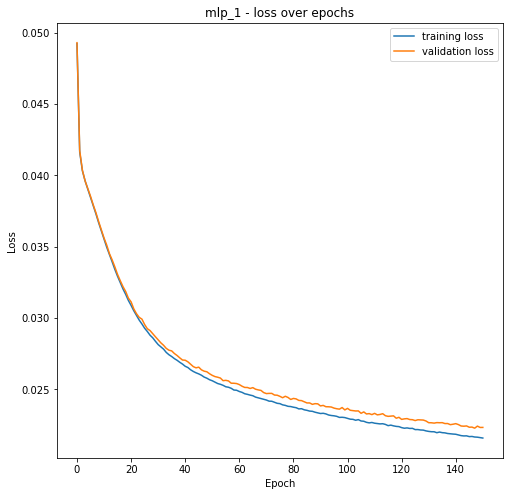

In [16]:
train_losses, val_losses = train(mlp_1, dataloaders["train"], dataloaders["val"], "mlp_1",\
                                 lr=1e-3, patience=10, max_epoch=500, device=device)

In [17]:
pytorch_total_params = sum(p.numel() for p in mlp_2.parameters() if p.requires_grad)
print(f"Trainable params: {pytorch_total_params//(10**6)}M")

Trainable params: 3M


Epoch:  33%|███▎      | 166/500 [54:44<1:50:09, 19.79s/it, Train loss=0.0167, Val loss=0.0178]

Early stopped


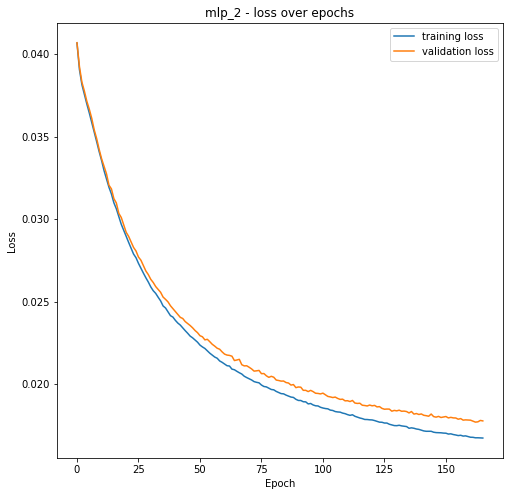

In [18]:
train_losses, val_losses = train(mlp_2, dataloaders["train"], dataloaders["val"], "mlp_2",\
                                 lr=1e-3, patience=10, max_epoch=500, device=device)

In [19]:
pytorch_total_params = sum(p.numel() for p in mlp_3.parameters() if p.requires_grad)
print(f"Trainable params: {pytorch_total_params//(10**6)}M")

Trainable params: 4M


Epoch:  40%|███▉      | 198/500 [1:05:08<1:39:22, 19.74s/it, Train loss=0.0174, Val loss=0.0184]

Early stopped


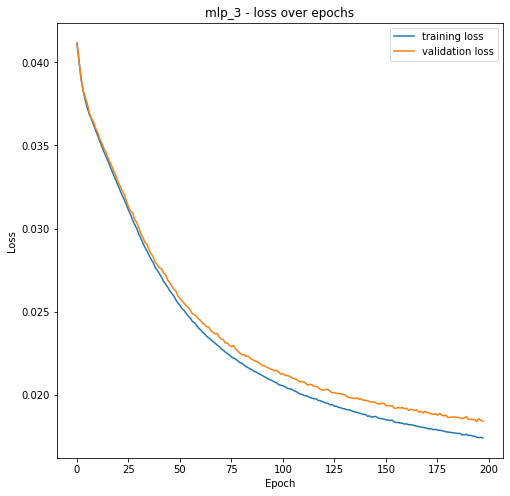

In [20]:
train_losses, val_losses = train(mlp_3, dataloaders["train"], dataloaders["val"], "mlp_3",\
                                 lr=5e-4, patience=10, max_epoch=500, device=device)

In [21]:
pytorch_total_params = sum(p.numel() for p in mlp_1s.parameters() if p.requires_grad)
print(f"Trainable params: {pytorch_total_params//(10**6)}M")

Trainable params: 1M


Epoch:  28%|██▊       | 142/500 [48:07<2:01:20, 20.34s/it, Train loss=0.0238, Val loss=0.0243]

Early stopped


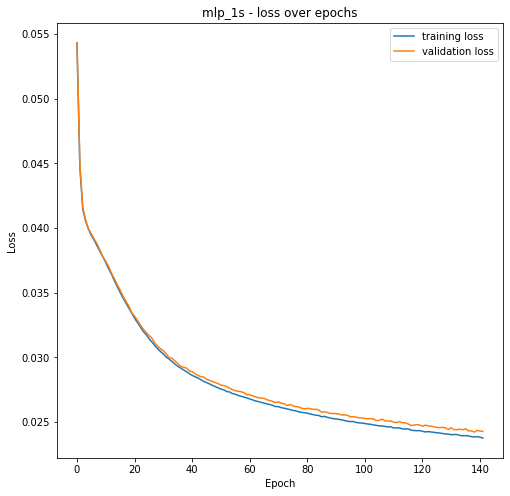

In [22]:
train_losses, val_losses = train(mlp_1s, dataloaders["train"], dataloaders["val"], "mlp_1s",\
                                 lr=1e-3, patience=10, max_epoch=500, device=device)

In [23]:
pytorch_total_params = sum(p.numel() for p in mlp_2s.parameters() if p.requires_grad)
print(f"Trainable params: {pytorch_total_params//(10**6)}M")

Trainable params: 1M


Epoch:  31%|███       | 156/500 [56:22<2:04:19, 21.68s/it, Train loss=0.0196, Val loss=0.0201]

Early stopped


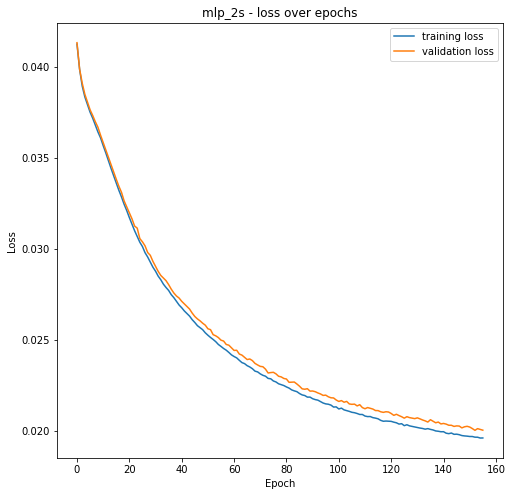

In [24]:
train_losses, val_losses = train(mlp_2s, dataloaders["train"], dataloaders["val"], "mlp_2s",\
                                 lr=1e-3, patience=10, max_epoch=500, device=device)

In [25]:
pytorch_total_params = sum(p.numel() for p in mlp_3s.parameters() if p.requires_grad)
print(f"Trainable params: {pytorch_total_params//(10**6)}M")

Trainable params: 1M


Epoch:  32%|███▏      | 161/500 [58:25<2:03:00, 21.77s/it, Train loss=0.0196, Val loss=0.0201]

Early stopped


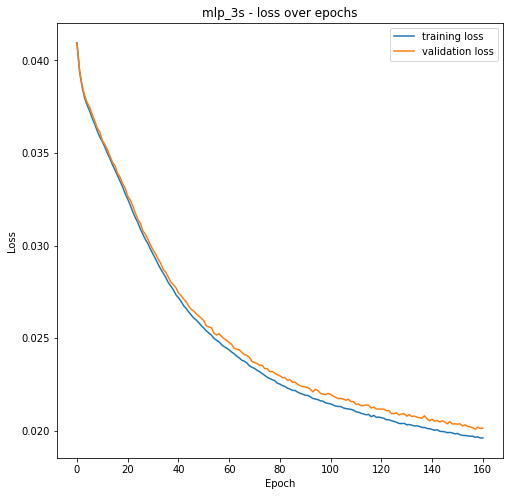

In [26]:
train_losses, val_losses = train(mlp_3s, dataloaders["train"], dataloaders["val"], "mlp_3s",\
                                 lr=1e-3, patience=10, max_epoch=500, device=device)

## Prediction

In [10]:
class PredictorFF():
    def __init__(self,model, max_mz=1001, threshold=.5):
        self.model = model
        self.max_mz= max_mz
        self.threshold = threshold
        
    @classmethod
    def from_file(cls, file, device="cpu", max_mz=1001, threshold=.5):
        model = torch.load(file,  map_location=torch.device(device)) 
        return cls(model, max_mz=max_mz, threshold=threshold)
   

    def __call__(self, X):
        with torch.no_grad():
            return self.model(X)
    
    def predict_random_all(self, ds, probs, cum_level=.95, filtered=True, \
                           device="cpu", **kwargs):
        # reset rng before each prediction to have comparable results
        self.rng = np.random.default_rng(42)

        spectrums = ds.spectrums
        m_pred_per_p = [[None for _ in range(len(spectrums))] for _ in range(len(probs))]
        m_y_per_p = [[None for _ in range(len(spectrums))] for _ in range(len(probs))]
        some_pred_per_p = [[None for _ in range(len(spectrums))] for _ in range(len(probs))]
        
        for i, spec in enumerate(spectrums):
            vect = get_mz_vector(spec, self.max_mz)
            
            mat = np.zeros(shape=(len(probs),vect.shape[0]), dtype=np.float32)

            his_size = get_his_size(spec, cum_level)
            his_ind = np.argpartition(vect, -his_size)[-his_size:]
       
            for m, p in enumerate(probs):
                
                ## cripple vector
                mat[m] = vect.copy()
                
                mask_missing = self.rng.uniform(0,1, self.max_mz) < p
                                
                mat[m][mask_missing] = 0
                
                his_mask = np.zeros_like(vect) == 1
                his_mask[his_ind] = True
                
                m_y_per_p[m][i] = np.where(mask_missing & his_mask)[0]
                
            # get predictions
            with torch.no_grad():
                mat_ = torch.from_numpy(mat).to(device)
                pred = self.model(mat_)
                pred = pred.cpu().numpy()    
            
            if filtered:
                pred[mat!=0] = 0
                
            # get best peaks above threshold (except the given ones)    
            for m in range(len(probs)):
                some = np.where(pred[m] > self.threshold)[0]
                some_pred_per_p[m][i] = some
            
            # get best m peaks (except the given ones)
            for m in range(len(probs)):
                next_m = np.argsort(pred[m])[::-1][:len(m_y_per_p[m][i])]
                m_pred_per_p[m][i] = next_m     
            
        return some_pred_per_p, m_pred_per_p, m_y_per_p



# Linear

## Visualisation

In [11]:
from msai.plots import plot_spectrum_predictions_random

predictor = PredictorFF.from_file(f"models/{kind}/linear", max_mz=1001)
predictor.model.cpu()

Linear(
  (linear): Linear(in_features=1001, out_features=1001, bias=True)
  (sigm): Sigmoid()
)

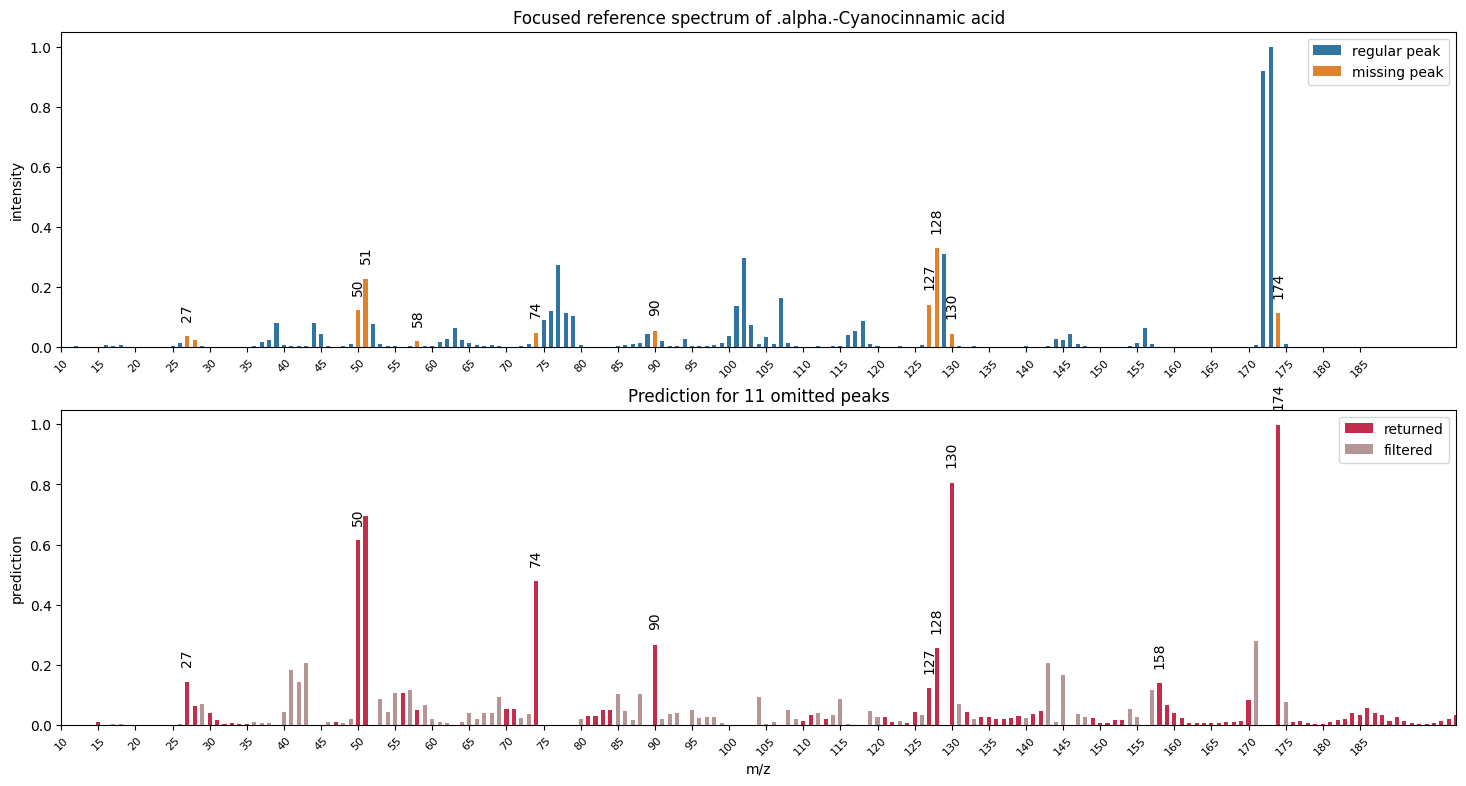

In [29]:
i  = 4444
datasets["fixed_val"].reset_rng(42)
X, y = datasets["fixed_val"][i]
pred = predictor(X).cpu().numpy()
plot_spectrum_predictions_random(documents_val[i], np.where(y!=0)[0], pred, \
                                 BasicCoder(max_mz=predictor.max_mz), plot_full=False, \
                                 save_to_path=f"figures/{kind}/visual/linear_val.pdf")


## Model Selection
done on the val set

In [12]:
P_FOLDER = f"predictions/{kind}"
probs = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5]

In [15]:
import os

predictors = { 
            "linear_.8": PredictorFF.from_file(f"models/{kind}/linear", max_mz=1001, device=device, threshold=.8),
            "linear_.5": PredictorFF.from_file(f"models/{kind}/linear", max_mz=1001, device=device, threshold=.5),
            "linear_.3": PredictorFF.from_file(f"models/{kind}/linear", max_mz=1001, device=device, threshold=.3),
            "linear_.1": PredictorFF.from_file(f"models/{kind}/linear", max_mz=1001, device=device, threshold=.1)
}


In [16]:
P_FOLDER

'predictions/de_novo'

In [17]:
from msai.evaluation import calc_predictions_random, load_predictions_random, model_selection_random
from msai.plots import plot_scores

In [34]:
%%time
calc_predictions_random(probs, predictors, datasets, "fixed_val", P_FOLDER, batch_size=512, device=device, verbose=True)

linear_.8


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


linear_.5
linear_.3
linear_.1
CPU times: user 2min 34s, sys: 1.25 s, total: 2min 35s
Wall time: 2min 39s


In [18]:
best_p_name, scores = model_selection_random(P_FOLDER, "fixed_val", predictors=predictors)

linear_.5


/auto/brno6/home/xstary1/raims/metrics.py:232: RuntimeWarning: Mean of empty slice
  "mp": np.nanmean(recs_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:234: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:235: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


linear_.3
linear_.8
linear_.1


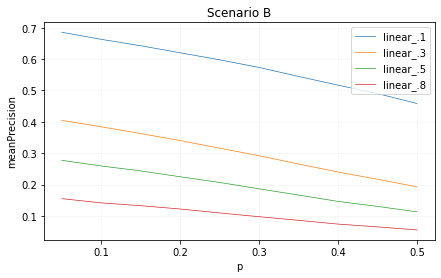

In [19]:
orderer_f = lambda x: (x.split("_")[1])
hue_f = lambda x: [1,3,5,8].index(int(x.split("_")[1][1]))
plot_scores(scores, metrics="mp", x=probs,
            orderer_f=orderer_f,hue_f=hue_f,
            title= "Scenario B" if kind=="de_novo" else "Scenario A",
            xlabel= "p", ylabel="meanPrecision",
            save_to_path=f"figures/{kind}/selection/lr_val_prec.pdf")

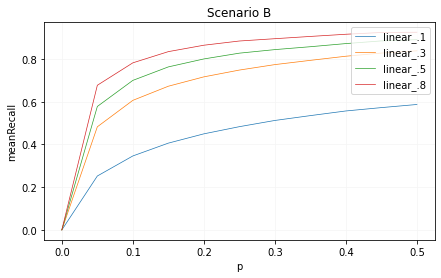

In [20]:
plot_scores(scores, metrics="mr", x=probs,
            orderer_f=orderer_f,hue_f=hue_f,
            title= "Scenario B" if kind=="de_novo" else "Scenario A",
            xlabel= "p", ylabel="meanRecall",
            save_to_path=f"figures/{kind}/selection/lr_val_rec.pdf")

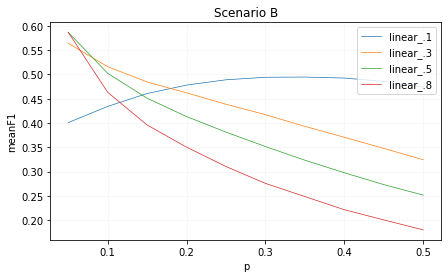

In [21]:
plot_scores(scores, metrics="mf1", x=probs,
            orderer_f=orderer_f,hue_f=hue_f,
            title= "Scenario B" if kind=="de_novo" else "Scenario A",
            xlabel= "p", ylabel="meanF1",
            save_to_path=f"figures/{kind}/selection/lr_val_f1.pdf")

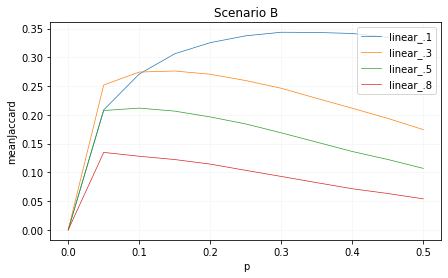

In [22]:
plot_scores(scores, metrics="mj", x=probs,
            orderer_f=orderer_f,hue_f=hue_f,
            title= "Scenario B" if kind=="de_novo" else "Scenario A",
            xlabel= "p", ylabel="meanJaccard",
            save_to_path=f"figures/{kind}/selection/lr_val_jac.pdf")

In [23]:
scores

{'linear_.5': {'mr': array([0.        , 0.57756462, 0.69953993, 0.76265841, 0.79987491,
         0.82692804, 0.84352558, 0.85707427, 0.87171944, 0.88427085,
         0.88997584]),
  'mp': array([       nan, 0.2770421 , 0.2590788 , 0.24331675, 0.22473248,
         0.20662101, 0.18624371, 0.1663738 , 0.14615925, 0.13029404,
         0.11298259]),
  'mj': array([0.        , 0.20761052, 0.21176065, 0.20655225, 0.19643218,
         0.18424364, 0.16881024, 0.15260023, 0.13633794, 0.12247303,
         0.10698337]),
  'mf1': array([       nan, 0.58663158, 0.50221784, 0.45093939, 0.41312487,
         0.381115  , 0.3514019 , 0.32324295, 0.29743868, 0.27299225,
         0.25138994]),
  'mps': array([       nan, 0.47879824, 0.50543481, 0.52444581, 0.53501738,
         0.54165381, 0.54388994, 0.5423438 , 0.54084937, 0.53722096,
         0.53250774])},
 'linear_.3': {'mr': array([0.        , 0.4824124 , 0.60612435, 0.6722777 , 0.71605312,
         0.74784287, 0.77338269, 0.79328861, 0.81257984, 0.82

In [24]:
best_p_name

'linear_.1'

## Visualisation of the best predictor

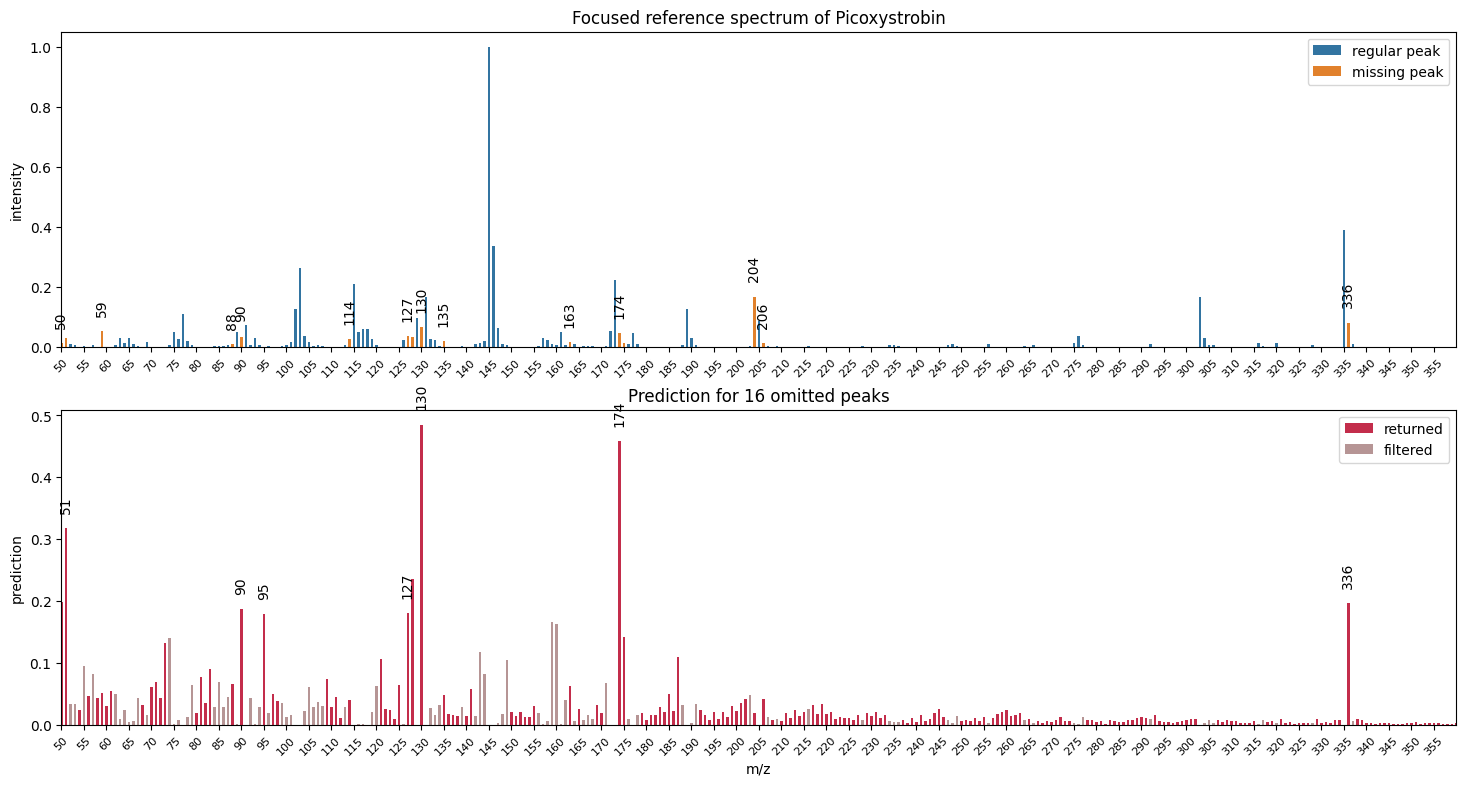

In [51]:
i  = 22464
datasets["fixed_test"].reset_rng(42)
X, y = datasets["fixed_test"][i]
pred = predictors[best_p_name](X.to(device)).cpu().numpy()
plot_spectrum_predictions_random(documents_test[i], np.where(y!=0)[0], pred, BasicCoder(max_mz=predictors[best_p_name].max_mz), plot_full=False)


In [ ]:
from msai.plots import plot_spectrum_predictions_random

for i in range(len(documents_test)):
    if i != 22464:
        continue
    if documents_test[i].metadata["name"] not in interesting:
        continue
    print(documents_test[i].metadata["name"])
    for seed in range(8):
        datasets["fixed_test"].reset_rng(seed)
        X, y = datasets["fixed_test"][i]
        pred = predictors[best_p_name](X.to(device)).cpu().numpy()
        
        #get predicted peaks
        zeroed = pred
        zeroed[X!=0] = 0
        peaks = np.nonzero([zeroed > predictors[best_p_name].threshold])[1]
        print(peaks)
        plot_spectrum_predictions_random(documents_test[i], np.where(y!=0)[0], pred, \
                                         BasicCoder(max_mz=predictors[best_p_name].max_mz), plot_full=False, predicted_peaks=peaks,
                                         save_to_path=f"figures/{kind}/visual/linear_test_{i}_random{seed}.pdf")

## Final evaluation of the best predictor 
done on the test set

In [53]:
%%time
calc_predictions_random(probs, {best_p_name: predictors[best_p_name]}, datasets, "fixed_test", P_FOLDER, batch_size=512, device=device, verbose=True)

linear_.1


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


CPU times: user 39.3 s, sys: 551 ms, total: 39.8 s
Wall time: 41 s


# MLP

## Visualisation

In [54]:
from msai.plots import plot_spectrum_predictions_random

predictor = PredictorFF.from_file(f"models/{kind}/mlp_1", max_mz=1001)
predictor.model.cpu()

MLP(
  (relu): ReLU()
  (layers): Sequential(
    (0): Linear(in_features=1001, out_features=1000, bias=True)
  )
  (linear): Linear(in_features=1000, out_features=1001, bias=True)
  (sigm): Sigmoid()
)

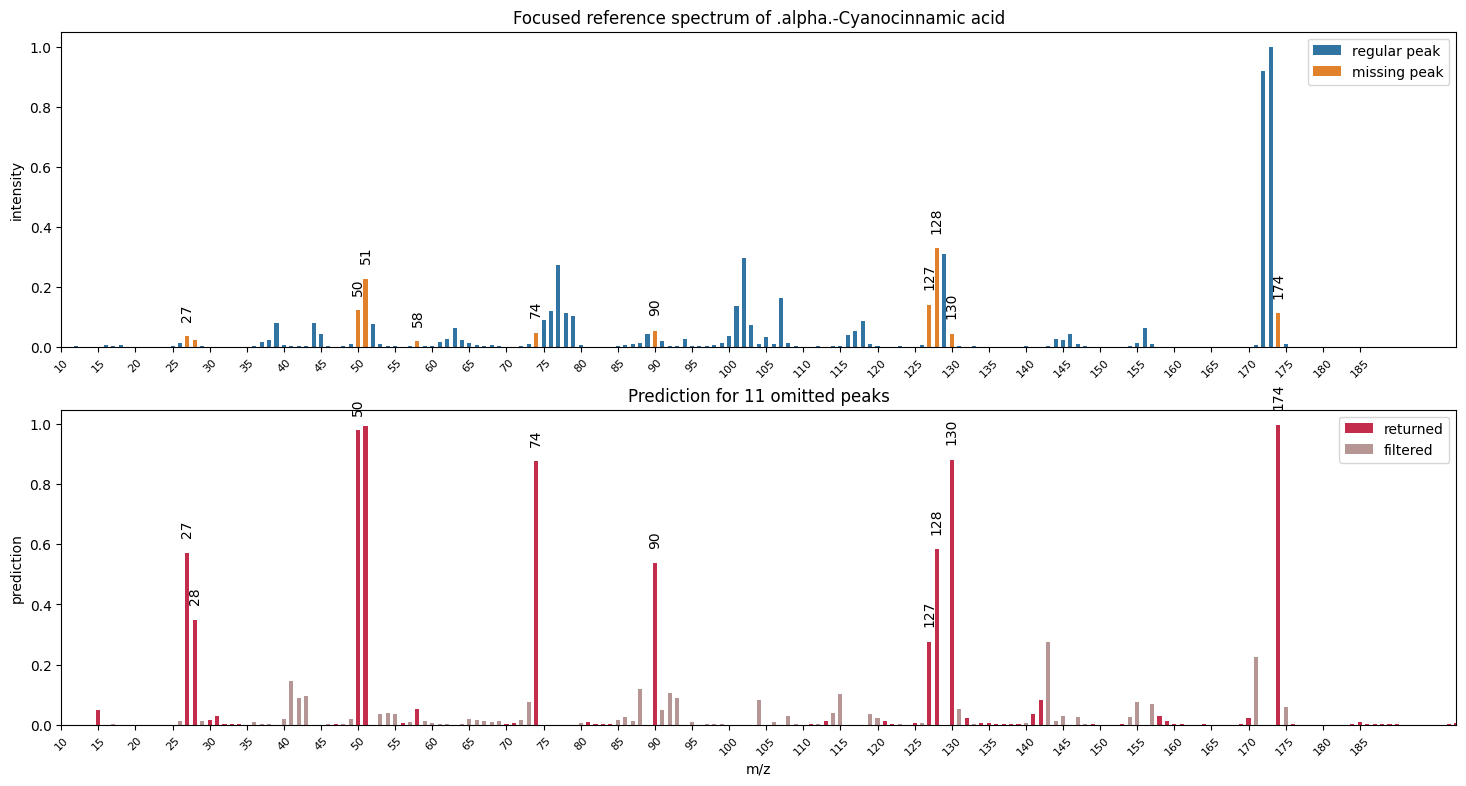

In [55]:
i  = 4444
datasets["fixed_val"].reset_rng(42)
X, y = datasets["fixed_val"][i]
pred = predictor(X).cpu().numpy()
plot_spectrum_predictions_random(documents_val[i], np.where(y!=0)[0], pred, \
                                 BasicCoder(max_mz=predictor.max_mz), plot_full=False, \
                                 save_to_path=f"figures/{kind}/visual/mlp_1_val.pdf")


## Model Selection
done on the val set

In [29]:
P_FOLDER = f"predictions/{kind}"
probs = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5]

In [30]:
import os

predictors = { 
            "mlp_1_.8": PredictorFF.from_file(f"models/{kind}/mlp_1", max_mz=1001, device=device, threshold=.8),
            "mlp_1_.5": PredictorFF.from_file(f"models/{kind}/mlp_1", max_mz=1001, device=device, threshold=.5),
            "mlp_1_.3": PredictorFF.from_file(f"models/{kind}/mlp_1", max_mz=1001, device=device, threshold=.3),
            "mlp_1_.1": PredictorFF.from_file(f"models/{kind}/mlp_1", max_mz=1001, device=device, threshold=.1),
            "mlp_2_.8": PredictorFF.from_file(f"models/{kind}/mlp_2", max_mz=1001, device=device, threshold=.8),
            "mlp_2_.5": PredictorFF.from_file(f"models/{kind}/mlp_2", max_mz=1001, device=device, threshold=.5),
            "mlp_2_.3": PredictorFF.from_file(f"models/{kind}/mlp_2", max_mz=1001, device=device, threshold=.3),
            "mlp_2_.1": PredictorFF.from_file(f"models/{kind}/mlp_2", max_mz=1001, device=device, threshold=.1),
            "mlp_3_.8": PredictorFF.from_file(f"models/{kind}/mlp_3", max_mz=1001, device=device, threshold=.8),
            "mlp_3_.5": PredictorFF.from_file(f"models/{kind}/mlp_3", max_mz=1001, device=device, threshold=.5),
            "mlp_3_.3": PredictorFF.from_file(f"models/{kind}/mlp_3", max_mz=1001, device=device, threshold=.3),
            "mlp_3_.1": PredictorFF.from_file(f"models/{kind}/mlp_3", max_mz=1001, device=device, threshold=.1),
            "mlp_2s_.8": PredictorFF.from_file(f"models/{kind}/mlp_2s", max_mz=1001, device=device, threshold=.8),
            "mlp_2s_.5": PredictorFF.from_file(f"models/{kind}/mlp_2s", max_mz=1001, device=device, threshold=.5),
            "mlp_2s_.3": PredictorFF.from_file(f"models/{kind}/mlp_2s", max_mz=1001, device=device, threshold=.3),
            "mlp_2s_.1": PredictorFF.from_file(f"models/{kind}/mlp_2s", max_mz=1001, device=device, threshold=.1)


}


In [31]:
P_FOLDER

'predictions/de_novo'

In [32]:
from msai.evaluation import calc_predictions_random, load_predictions_random, model_selection_random
from msai.plots import plot_scores

In [60]:
%%time
calc_predictions_random(probs, predictors, datasets, "fixed_val", P_FOLDER, batch_size=512, device=device, verbose=True)

mlp_1_.8


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


mlp_1_.5
mlp_1_.3
mlp_1_.1
mlp_2_.8
mlp_2_.5
mlp_2_.3
mlp_2_.1
mlp_3_.8
mlp_3_.5
mlp_3_.3
mlp_3_.1
mlp_2s_.8
mlp_2s_.5
mlp_2s_.3
mlp_2s_.1
CPU times: user 11min 26s, sys: 10.8 s, total: 11min 37s
Wall time: 11min 48s


In [33]:
best_p_name, scores = model_selection_random(P_FOLDER, "fixed_val", predictors=predictors)

mlp_1_.5


/auto/brno6/home/xstary1/raims/metrics.py:232: RuntimeWarning: Mean of empty slice
  "mp": np.nanmean(recs_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:234: RuntimeWarning: Mean of empty slice
  "mf1": np.nanmean(f1_some, axis=1),
/auto/brno6/home/xstary1/raims/metrics.py:235: RuntimeWarning: Mean of empty slice
  "mps": np.nanmean(precs_m, axis=1)


mlp_1_.3
mlp_2s_.1
mlp_1_.8
mlp_2_.3
mlp_2s_.3
mlp_1_.1
mlp_2_.1
mlp_2_.8
mlp_3_.1
mlp_2_.5
mlp_3_.8
mlp_3_.3
mlp_3_.5
mlp_2s_.8
mlp_2s_.5


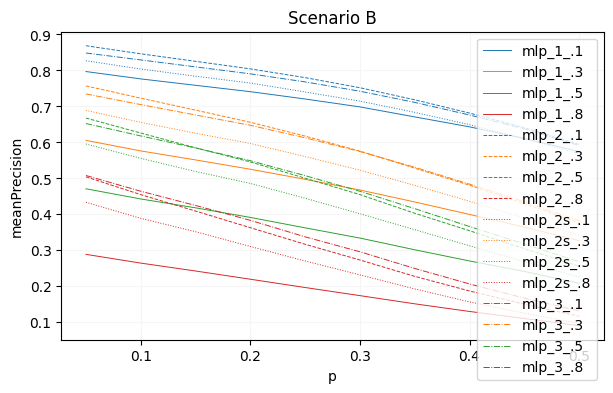

In [34]:
orderer_f = lambda x: (x.split("_")[1], x.split("_")[2][1])
hue_f = lambda x: [1,3,5,8].index(int(x.split("_")[2][1]))
plot_scores(scores, metrics="mp", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "Scenario B" if kind=="de_novo" else "Scenario A",
            xlabel= "p", ylabel="meanPrecision",
            save_to_path=f"figures/{kind}/selection/mlp_val_prec.pdf")

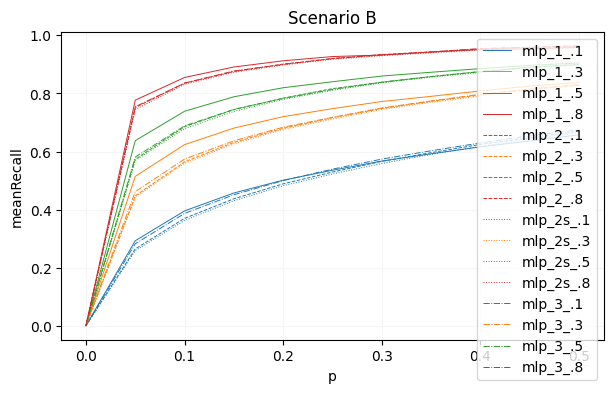

In [35]:
plot_scores(scores, metrics="mr", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "Scenario B" if kind=="de_novo" else "Scenario A",
            xlabel= "p", ylabel="meanRecall",
            save_to_path=f"figures/{kind}/selection/mlp_val_rec.pdf")

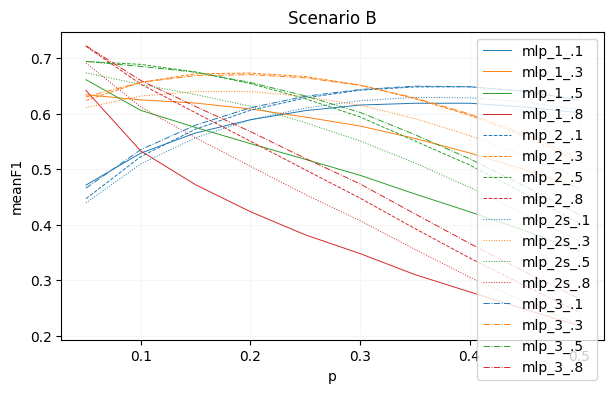

In [36]:

plot_scores(scores, metrics="mf1", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "Scenario B" if kind=="de_novo" else "Scenario A",
            xlabel= "p", ylabel="meanF1",
            save_to_path=f"figures/{kind}/selection/mlp_val.pdf"
           )



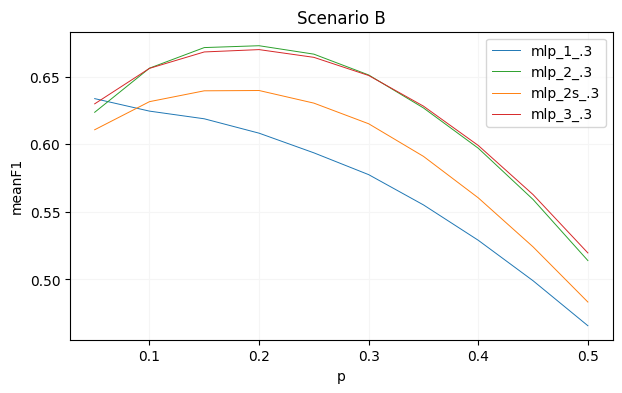

In [49]:
s = {key:scores[key] for key in scores if ".3" in key}

plot_scores(s, metrics="mf1", x=probs, grouper_f=lambda x: x.split("_")[0],
            orderer_f=orderer_f,hue_f=lambda x:["1", "2s","2", "3"].index(x.split("_")[1]),
            title= "Scenario B" if kind=="de_novo" else "Scenario A",
            xlabel= "p", ylabel="meanF1",
            save_to_path=f"figures/{kind}/selection/mlp_val_sel.pdf"
           )


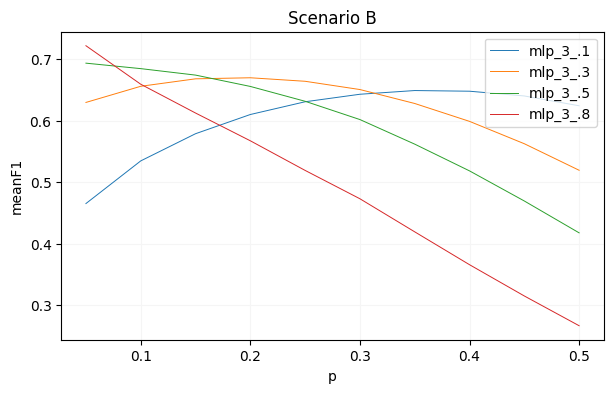

In [46]:
s = {key:scores[key] for key in scores if "_3" in key}

plot_scores(s, metrics="mf1", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "Scenario B" if kind=="de_novo" else "Scenario A",
            xlabel= "p", ylabel="meanF1",
            save_to_path=f"figures/{kind}/selection/mlp_val_sel3.pdf"
           )

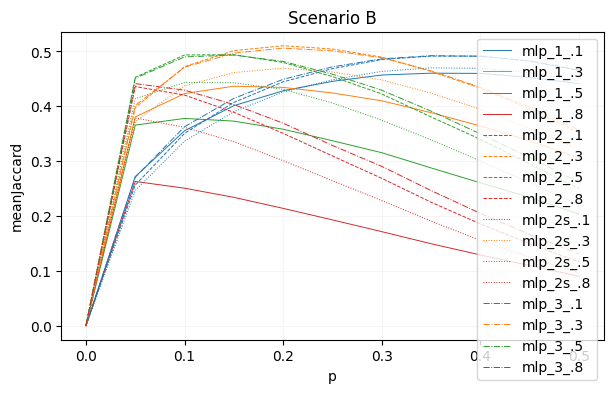

In [37]:
plot_scores(scores, metrics="mj", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "Scenario B" if kind=="de_novo" else "Scenario A",
            xlabel= "p", ylabel="meanJaccard",
            save_to_path=f"figures/{kind}/selection/mlp_val_jac.pdf"
           )


In [ ]:
scores

In [39]:
best_p_name

'mlp_3_.3'

## Visualisation of the best predictor

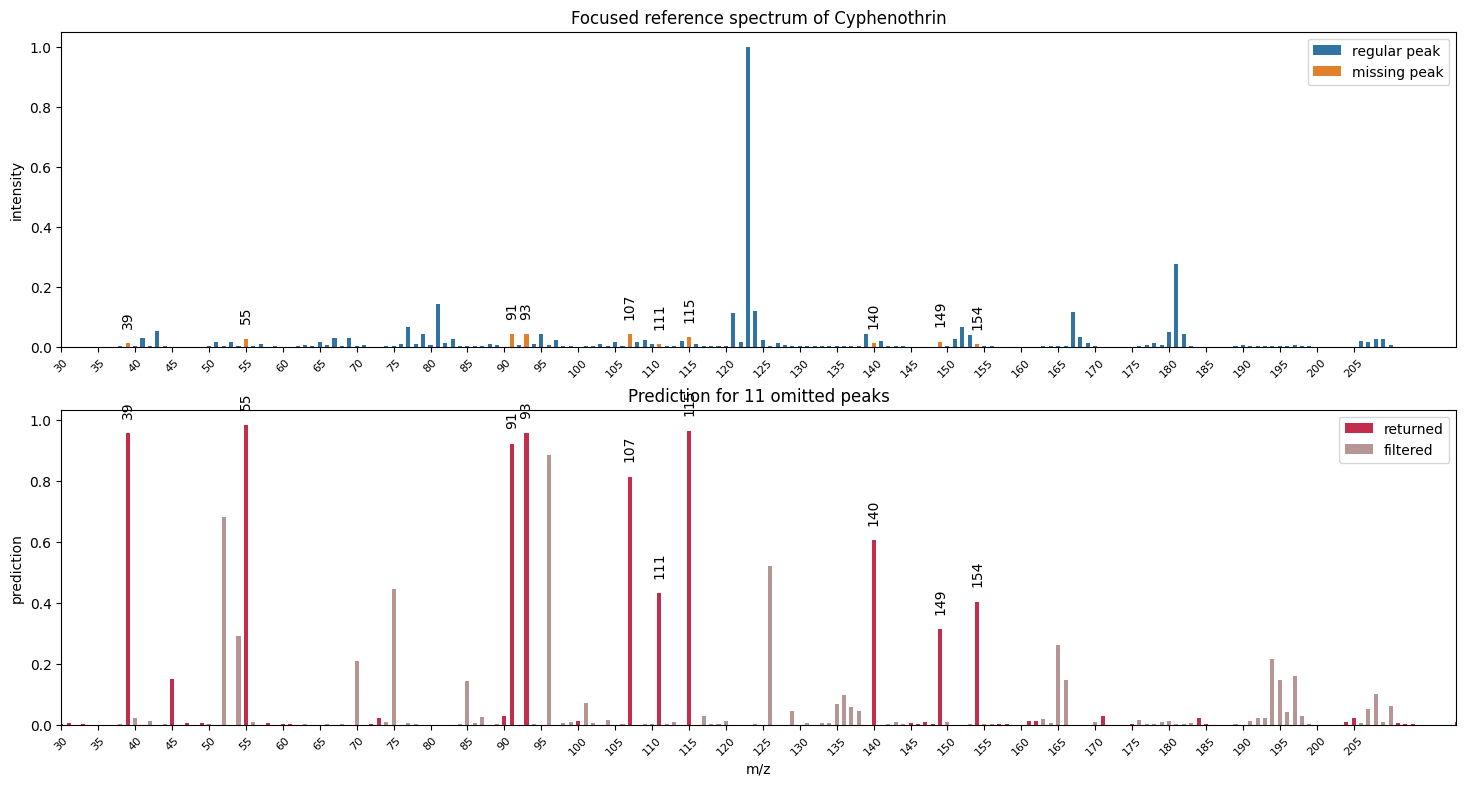

In [68]:
i  = 23073
datasets["fixed_test"].reset_rng(1)
X, y = datasets["fixed_test"][i]
pred = predictors[best_p_name](X.to(device)).cpu().numpy()
plot_spectrum_predictions_random(documents_test[i], np.where(y!=0)[0], pred, \
                                 BasicCoder(max_mz=predictors[best_p_name].max_mz), plot_full=False, \
                                save_to_path=f"figures/{kind}/visual/mlp_best_test.pdf")



In [ ]:
from msai.plots import plot_spectrum_predictions_random

for i in range(len(documents_test)):
    if documents_test[i].metadata["name"] not in interesting:
        continue
    print(documents_test[i].metadata["name"])
    for seed in range(8):
        datasets["fixed_test"].reset_rng(seed)
        X, y = datasets["fixed_test"][i]
        pred = predictors[best_p_name](X.to(device)).cpu().numpy()
        
        #get predicted peaks
        zeroed = pred
        zeroed[X!=0] = 0
        peaks = np.nonzero([zeroed > predictors[best_p_name].threshold])[1]
        print(peaks)
        
        plot_spectrum_predictions_random(documents_test[i], np.where(y!=0)[0], pred, \
                                         BasicCoder(max_mz=predictors[best_p_name].max_mz), plot_full=False, predicted_peaks=peaks,
                                         save_to_path=f"figures/{kind}/visual/mlp_test_{i}_random{seed}.pdf")

## Final evaluation of the best predictor 
done on the test set

In [70]:
%%time
calc_predictions_random(probs, {best_p_name: predictors[best_p_name]}, datasets, "fixed_test", P_FOLDER, batch_size=512, device=device, verbose=True)

mlp_3_.3


/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


CPU times: user 44 s, sys: 634 ms, total: 44.7 s
Wall time: 45.1 s


mlp_3_.3


/mnt/storage-brno6/home/xstary1/raims/metrics.py:224: RuntimeWarning: Mean of empty slice
  mean_rec_some = np.nanmean(recs_some, axis=1)
/mnt/storage-brno6/home/xstary1/raims/metrics.py:226: RuntimeWarning: Mean of empty slice
  mean_f1_some = np.nanmean(f1_some, axis=1)
/mnt/storage-brno6/home/xstary1/raims/metrics.py:227: RuntimeWarning: Mean of empty slice
  mean_prec= np.nanmean(precs_m, axis=1)


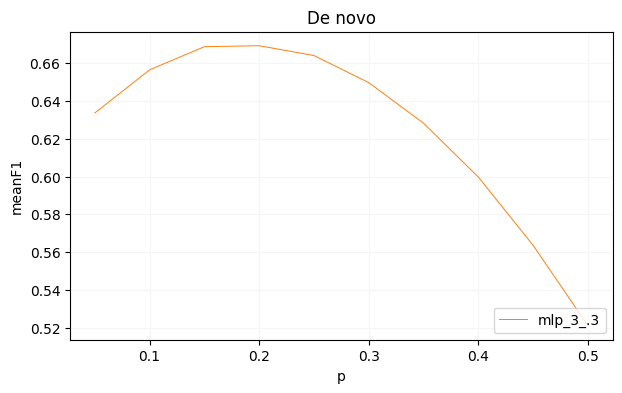

In [71]:
orderer_f = lambda x: (x.split("_")[1], x.split("_")[2][1])
hue_f = lambda x: [1,3,5,8].index(int(x.split("_")[2][1]))
best_p_name, scores_test = model_selection_random(P_FOLDER, "fixed_test", predictors={best_p_name: predictors[best_p_name]})
plot_scores(scores_test, metrics="mf1", x=probs, grouper_f=lambda x: x.split("_")[1],
            orderer_f=orderer_f,hue_f=hue_f,
            title= "De novo" if kind=="de_novo" else "In database",
            xlabel= "p", ylabel="meanF1",
            save_to_path=f"figures/{kind}/selection/mlp_test.pdf"
           )
